In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv("dat.csv")
df = df.drop(['employees_created'], axis=1)
df = df.drop(['employee_id'], axis=1)
df["age"] = df["age"].fillna(df["age"].mean())
from sklearn.preprocessing import LabelEncoder
df_a = df.copy()

# Create a label encoder object
le = LabelEncoder()
le_count = 0

le.fit(df_a['influx_route_big'])
# Transform both training and testing data
df_a['influx_route_big'] = le.transform(df_a['influx_route_big'])
df_b = pd.get_dummies(df_a['influx_route_big'], drop_first = True)

# one-hot encoding of categorical variables
df_b.columns = ['influx_0','influx_1','influx_2','influx_3','influx_4','influx_5','influx_6','influx_7']
df = pd.concat([df, df_b], axis=1)

df = df.drop(['influx_route_big'], axis=1)
pd.set_option('display.max_columns', 100)
df.head()

,entry_date_diffs,interview_date_diffs,open_count,mail_click,owned_visit,advertisement,career_change_desired_date_1,career_change_desired_date_2,career_change_desired_date_3,career_change_desired_date_4,now_status_1,now_status_2,now_status_3,now_status_4,now_status_5,contact_result_1,contact_result_2,contact_result_4,contact_result_5,objective_variable,influx_0,influx_1,influx_2,influx_3,influx_4,influx_5,influx_6,influx_7
0,10,10,5,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,8,1,4,5,6,1,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0
2,38,7,5,5,30,6,0,0,0,1,0,1,0,0,0,0,0,3,3,0,0,0,0,0,1,0,0,0
3,68,11,6,1,13,0,0,0,0,1,1,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0
4,6,5,5,3,18,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [6]:
df_train = df.copy()

#変数を配列へ変換
from sklearn.cross_validation import train_test_split

X = df_train.drop("objective_variable" , axis=1).values
y = df_train["objective_variable"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import grid_search

#aucでやってみる。http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html

grid = {'C':[0.0001, 0.001, 0.01, 0.1,1,10,100,1000,10000], 'solver': ['newton-cg']}   
# solverはスモールデータならliblinear、多クラスに分けるためにnewton-cg’

clf = LogisticRegression(penalty='l2', random_state=1, max_iter=10000, tol=10)
model = GridSearchCV(clf, grid, scoring='roc_auc', cv=5)

# model.fit(X_train, y_train)
model = model.fit(X_train, y_train)



C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [8]:
print ('model.best_score_:', model.best_score_)
print ('model.best_estimator_:', model.best_estimator_)

model.best_score_: 0.6996601733416566
model.best_estimator_: LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='newton-cg', tol=10,
          verbose=0, warm_start=False)


In [9]:
from sklearn import metrics as mtr

prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = mtr.roc_curve(y_test, prob, pos_label=1)
mtr.auc(fpr, tpr)

0.6872086623139995

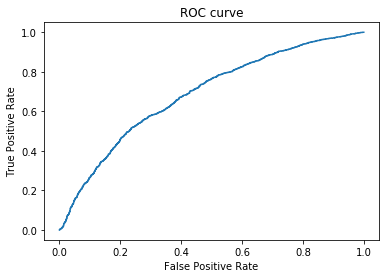

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [14]:
class_predict = model.predict(X_test)
# 精度を計算してみます。
print('テストデータに対する正解率： %.4f' %mtr.accuracy_score(y_test,class_predict))
print('テストデータに対する roc-auc： %.4f' %mtr.roc_auc_score(y_test, prob))
print('テストデータに対する log-loss： %.4f' %mtr.log_loss(y_test, prob))

テストデータに対する正解率： 0.6572
テストデータに対する roc-auc： 0.6872
テストデータに対する log-loss： 0.6254


C:\Users\ryosuke.nishioka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


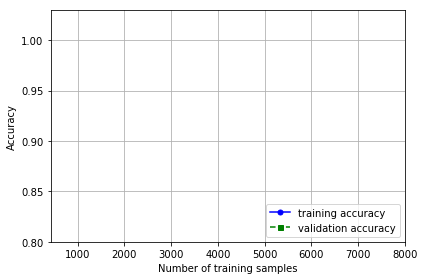

In [15]:
## 過学習が起きていないかを確認する
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve


#pipe_lr = make_pipeline(StandardScaler(),
   #                     LogisticRegression(penalty='l1', random_state=1))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=model,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
#plt.savefig('images/06_05.png', dpi=300)
plt.show()